In [1]:
import sys
sys.path.append(r"C:\Users\mohammed\OneDrive\Documents\QFM -S2\Solving PDE's using ANN\Solving-PDE-s-using-neural-network\src\neuraloperator")

In [197]:
import torch
import matplotlib.pyplot as plt
import sys
import os
from neuraloperator.neuralop.models import FNO
from neuraloperator.neuralop import Trainer
from neuraloperator.neuralop.training import AdamW
from neuraloperator.neuralop.data.datasets import load_darcy_flow_small
from neuraloperator.neuralop.utils import count_model_params
from neuraloperator.neuralop import LpLoss, H1Loss
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import torch.nn.functional as F
sys.path.append(r"C:\Users\mohammed\OneDrive\Documents\QFM -S2\Solving PDE's using ANN\Solving-PDE-s-using-neural-network")
from src.Operators.Diff_Op import pdeOperator



In [3]:
d = pdeOperator()
derivation = d.derivative

# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


In [ ]:
class PreloadedPINNDataset(Dataset):
    """Preloaded Dataset for Physics-Informed Neural Networks"""
    def __init__(self, x, y, p, u_exact=None, operator=None):
        self.samples = []  # Preload all samples here
        for idx in range(len(p)):
            try:
                exact = u_exact(x, y, p[idx])
                f = operator(exact, x, y)
            except:
                exact.requires_grad = True
                f = derivation_fdm(exact, x) + derivation_fdm(exact, y)
                print(f"not well calculated at {idx}")
            sample = {
                'y': exact.reshape(1, exact.shape[0], exact.shape[1]),
                'x': f.reshape(1, f.shape[0], f.shape[1])
            }
            self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


# Create dataset
X = torch.linspace(-1, 1, 16, requires_grad=True)
Y = torch.linspace(-1, 1, 16, requires_grad=True)
X, Y = torch.meshgrid(X, Y)
X = X.unsqueeze(-1)
Y = Y.unsqueeze(-1)

u_exact = lambda x, y, p: torch.exp(p * (-x**2 - y**2))
operator = lambda u, x, y: derivation(u, x, order=2) + derivation(u, y, order=2)

# Preload dataset
p_values = np.linspace(5, 15, 20)
dataset = PreloadedPINNDataset(X, Y, p_values, u_exact, operator)

# Split dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
all_x_train = torch.cat([sample['x'] for sample in train_dataset] , dim = 0 )
all_x_test = torch.cat([sample['x'] for sample in test_dataset] , dim = 0 )
print(all_x_train.shape)
y_train = torch.cat([sample['y'] for sample in train_dataset] , dim = 0 )
y_test = torch.cat([sample['y'] for sample in test_dataset] , dim = 0 )

x_normalizer = UnitGaussianNormalizer(all_x_train)
x_train = x_normalizer.encode(all_x_train)
print(x_train.shape)
x_test = x_normalizer.encode(all_x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

train_dataset_normalized = [{'x': x_train[i].unsqueeze(0), 'y': y_train[i].unsqueeze(0)} for i in range(len(x_train))]
test_dataset_normalized = [{'x': x_test[i].unsqueeze(0), 'y': y_test[i].unsqueeze(0)} for i in range(len(x_test))]

#train_dataset = 

# Create DataLoader
train_loader = DataLoader(train_dataset , batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset , batch_size=32, shuffle=False)

test_loaders = {16: test_loader}
train_loaders = {16: train_loader}



In [ ]:
def create_data_pipeline(resolution=16, p_min=5, p_max=15, n_samples=20, batch_size=32):
    """Create training and testing data pipeline"""
    
    # Create grid
    X = torch.linspace(-1, 1, resolution, requires_grad=True)
    Y = torch.linspace(-1, 1, resolution, requires_grad=True)
    X, Y = torch.meshgrid(X, Y)
    X = X.unsqueeze(-1)
    Y = Y.unsqueeze(-1)

    # Define functions
    u_exact = lambda x, y, p: torch.exp(p * (-x**2 - y**2))
    operator = lambda u, x, y: derivation(u, x, order=2) + derivation(u, y, order=2)

    # Create p values
    p_values = np.linspace(p_min, p_max, n_samples)
    
    # Create dataset
    dataset = PreloadedPINNDataset(X, Y, p_values, u_exact, operator)

    # Split dataset
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Concatenate data for normalization
    all_x_train = torch.cat([sample['x'] for sample in train_dataset], dim=0)
    all_x_test = torch.cat([sample['x'] for sample in test_dataset], dim=0)
    y_train = torch.cat([sample['y'] for sample in train_dataset], dim=0)
    y_test = torch.cat([sample['y'] for sample in test_dataset], dim=0)

    # Normalize data
    x_normalizer = UnitGaussianNormalizer(all_x_train)
    x_train = x_normalizer.encode(all_x_train)
    x_test = x_normalizer.encode(all_x_test)

    y_normalizer = UnitGaussianNormalizer(y_train)
    y_train = y_normalizer.encode(y_train)

    # Create normalized datasets
    train_dataset_normalized = [
        {'x': x_train[i].unsqueeze(0), 'y': y_train[i].unsqueeze(0)} 
        for i in range(len(x_train))
    ]
    test_dataset_normalized = [
        {'x': x_test[i].unsqueeze(0), 'y': y_test[i].unsqueeze(0)} 
        for i in range(len(x_test))
    ]

    # Create data loaders
    train_loader = DataLoader(train_dataset_normalized, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset_normalized, batch_size=batch_size, shuffle=False)

    return {
        'train_loader': {resolution: train_loader},
        'test_loader': {resolution: test_loader},
        'normalizers': {
            'x': x_normalizer,
            'y': y_normalizer
        }
    }



data_pipeline = create_data_pipeline(resolution=16, p_min=5, p_max=15, n_samples=20, batch_size=32)

train_loader = data_pipeline['train_loader'][16]
test_loader = data_pipeline['test_loader'][16]

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

class FVMDerivatives:
    def __init__(self, nx, ny, domain=None):
        # Default domain if none specified
        self.domain = domain or {
            'x': [-1, 1],  # [x_min, x_max]
            'y': [-1, 1],  # [y_min, y_max]
            'boundary_conditions': {
                'left': 0,
                'right': 0,
                'top': 0,
                'bottom': 0
            }
        }
        
        self.nx, self.ny = nx, ny
        self.dx = (self.domain['x'][1] - self.domain['x'][0])/nx
        self.dy = (self.domain['y'][1] - self.domain['y'][0])/ny
        
        # Generate grid
        self.x = torch.linspace(
            self.domain['x'][0] + self.dx/2, 
            self.domain['x'][1] - self.dx/2, 
            nx
        )
        self.y = torch.linspace(
            self.domain['y'][0] + self.dy/2,
            self.domain['y'][1] - self.dy/2,
            ny
        )
        
        # Create mesh
        self.X, self.Y = torch.meshgrid(self.x, self.y, indexing='ij')
        
    def apply_boundary_conditions(self, u):
        """Apply boundary conditions from the domain."""
        bc = self.domain['boundary_conditions']
        u[0, :] = bc['bottom']  # Bottom boundary
        u[-1, :] = bc['top']    # Top boundary
        u[:, 0] = 0 #bc['left']    # Left boundary
        u[:, -1] = 0 #bc['right']  # Right boundary
        return u
    
    def gradient(self, u):
        """Calculate gradient using FVM"""
        # Initialize gradients
        grad_x = torch.zeros_like(u)
        grad_y = torch.zeros_like(u)
        
        # Interior points
        grad_x[1:-1, :] = (u[2:, :] - u[:-2, :]) / (2 * self.dx)
        grad_y[:, 1:-1] = (u[:, 2:] - u[:, :-2]) / (2 * self.dy)
        
        # Apply boundary conditions
        grad_x = self.apply_boundary_conditions(grad_x)
        grad_y = self.apply_boundary_conditions(grad_y)
        
        return grad_x, grad_y
    
    def laplacian(self, u):
        """Calculate Laplacian using FVM"""
        laplacian = torch.zeros_like(u)
        
        # Interior points
        laplacian[1:-1, 1:-1] = (
            (u[2:, 1:-1] - 2 * u[1:-1, 1:-1] + u[:-2, 1:-1]) / (self.dx**2) +
            (u[1:-1, 2:] - 2 * u[1:-1, 1:-1] + u[1:-1, :-2]) / (self.dy**2)
        )
        
        # Apply boundary conditions
        laplacian = self.apply_boundary_conditions(laplacian)
        
        return laplacian
    

# Example usage
x = torch.linspace(-1, 1, 16, requires_grad=True)
y = torch.linspace(-1, 1, 16, requires_grad=True)
X, Y = torch.meshgrid(x, y)
u = torch.exp(-1 * ((X)**2 + (Y)**2))

domain = {
    'x': [-1, 1],
    'y': [-1, 1],
    'boundary_conditions': {
        'left': u[:, 0],
        'right': u[:, -1],
        'top': u[-1, :],
        'bottom': u[0, :]
    }
}

fvm = FVMDerivatives(16, 16, domain=domain)

# Test function
X, Y = torch.meshgrid(fvm.x, fvm.y, indexing='ij')
X.requires_grad = True
Y.requires_grad = True
U =  []
for p in p_values[:1]:
    print(p)
    U.append(torch.exp(p * (-X**2 - Y**2)).unsqueeze(0))

U = torch.stack(U , dim = 0)
print(U.shape)
# Auto-diff Laplacian
i = 0
auto_lap = derivation(U[i] , X , order=2) + derivation(U[i] , Y , order=2)

# Calculate derivatives
#grad_x, grad_y = fvm.gradient(u)
Lap = fvm.laplacian(U.reshape(1 * 16, 16))
Lap = Lap.reshape(1, 16, 16)
lap = Lap[i]

error = torch.abs(lap - auto_lap).max()

print(f'Gradient error: {error:.2e}')

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title('True Laplacian') 
plt.imshow(lap.detach().numpy())
plt.colorbar()
plt.subplot(132)
plt.title('Auto-diff Laplacian')
plt.imshow(auto_lap.detach().numpy())
plt.colorbar()
plt.subplot(133)
plt.title('Error')
plt.imshow(torch.abs(lap - auto_lap).detach().numpy())
plt.colorbar()
plt.show()


In [1010]:
class LossWrapper:
    def __init__(self, loss_fn):
        self.loss_fn = loss_fn
        self.fvm = FVMDerivatives(32, 32)
    def normalize_operator(self, operator):
        """Normalize PDE operator output"""
        return (operator - operator.mean()) / (operator.std() + 1e-8)

    """def pde_loss(self, pred, **sample):
        #print(pred.shape)
        total_loss = 0
        for i in range(pred.shape[0]):
            operator = self.fvm.laplacian(pred[i].squeeze()).unsqueeze(0)
            loss = self.loss_fn(operator.squeeze(), sample['x'][i].squeeze())
            if loss == float('inf') or loss == float('nan'):
                loss = 0
                print(f"loss is inf or nan at {i}")
            total_loss += loss

        print(operator.shape ,  sample['x'].shape)
        return total_loss"""
    
    def pde_loss(self, pred, **sample):
        domain = {
            'x': [-1, 1],
            'y': [-1, 1],
            'boundary_conditions': {
                'left': u[:, 0],
                'right': u[:, -1],
                'top': u[-1, :],
                'bottom': u[0, :]
            }
        }

        fvm = FVMDerivatives(32, 32, domain=domain)
        
        try:
            # Batch laplacian calculation
            
            #pred = x_normalizer.decode(pred)
            
            batch_size = pred.shape[0] 
            
            operator = self.fvm.laplacian(pred.reshape(batch_size* pred.shape[2]  , pred.shape[3]  )).reshape(pred.shape)
            
            # Compute loss and mask inf/nan values
            #exact_f = y_normalizer.decode(sample['x'])
            #operator = operator[: , 1:-1 , 1:-1]
            target = sample['x']
            #target = target[: , 1:-1 , 1:-1]
            loss = self.loss_fn(operator, target)
            mask = torch.isfinite(loss)
            
            # Sum valid losses only
            total_loss = torch.where(mask, loss, torch.zeros_like(loss)).sum()
            #print(operator)
            
            """if not torch.isfinite(total_loss):
                print("Warning: Invalid total loss detected")
                return torch.tensor(0.0, requires_grad=True, device=pred.device)"""
                
            return loss
            
        except RuntimeError as e:
            print(f"Error in PDE loss calculation: {e}")
            return torch.tensor(0.0, requires_grad=True, device=pred.device)
        
    def calculate_buondary_conditions(self, u , **sample):
        u_exact = sample['y']
        u = u.squeeze()
        u_exact = u_exact.squeeze()
        
        if len(u.shape) == 2:
            u = u.unsqueeze(0)
            u_exact = u_exact.unsqueeze(0)
        
        boundary_conditions = {
            'left': u[:  , :, 0],
            'right': u[: , : , -1],
            'top': u[: , -1 , :],
            'bottom': u[ : , 0 , :]
        }

        exact_boundary_conditions = {
            'left': u_exact[: , :, 0],
            'right': u_exact[: , : , -1],
            'top': u_exact[: , -1 , :],
            'bottom': u_exact[ : , 0 , :]
        }


        loss = 0
        for key in boundary_conditions.keys():
            loss += self.loss_fn(boundary_conditions[key], exact_boundary_conditions[key])

        return loss
        

    
    def __call__(self, pred, **sample):
        target = sample.get('y', sample.get('target'))
        pde_loss = self.pde_loss(pred, **sample)

        boundary_loss = self.calculate_buondary_conditions(pred, **sample)
        error = pred - target
        error_boundary = error[: , : , 0] + error[: , : , -1] + error[: , 0 , :] + error[: , -1 , :]
        boundarie_error_mse = torch.mean(error_boundary**2)
        #print(f"pde_loss: {pde_loss} , boundary_loss: {boundary_loss} , error_mse: {error_mse}")

        return     pde_loss + boundarie_error_mse + self.loss_fn(pred, target)
    
    
class mse_loss:
    def __init__(self):
        self.loss_fn = F.mse_loss
    def __call__(self, pred, **sample):
        target = sample.get('y', sample.get('target'))
        return self.loss_fn(pred, target)
    
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)


pino_loss = LossWrapper(h1loss)
train_loss =  pino_loss  #  , 'mse_loss' : LossWrapper(F.mse_loss) 
eval_losses={'h1': h1loss, 'l2': l2loss ,'mse_loss' : mse_loss() }

In [1052]:
def fno_model(device = "cpu"):
    
    model = FNO(n_modes=(16, 16),
                in_channels=1,
                out_channels=1,
                hidden_channels=32,
                projection_channel_ratio=2)
    model = model.to(device)
    return model
device = "cpu"
model = FNO(n_modes=(16, 16),
            in_channels=1,
            out_channels=1,
            hidden_channels=32,
            projection_channel_ratio=2)
#model = Net(1, 1, 100, 5)
model = model.to(device)


n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 1192801 parameters.


In [1037]:
PINO_model = FNO(n_modes=(16, 16),
            in_channels=1,
            out_channels=1,
            hidden_channels=32,
            projection_channel_ratio=2)
#model = Net(1, 1, 100, 5)
PINO_model = PINO_model.to(device)

PINO_optimizer = AdamW(PINO_model.parameters(), lr=0.005)
PINO_scheduler = torch.optim.lr_scheduler.StepLR(PINO_optimizer, step_size=100, gamma=0.96)

In [1053]:
optimizer = AdamW(model.parameters(),
                                lr=0.008,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [907]:
import torch
import copy

def create_finetuning_model(original_model, learning_rate=1e-3):
    """Create copy of model for fine-tuning"""
    
    # Deep copy model and weights
    model_finetune = copy.deepcopy(original_model)
    
    # Create new optimizer
    optimizer = torch.optim.Adam(model_finetune.parameters(), lr=learning_rate)
    
    # Create scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                              step_size=100, 
                                              gamma=0.5)
    
    return model_finetune, optimizer, scheduler

# Usage
model_ft, optimizer_ft, scheduler_ft = create_finetuning_model(model , learning_rate=8e-3)

# Verify weights are copied but separate
print("Original model first parameter:", 
      next(model.parameters())[0,0])
print("Fine-tune model first parameter:", 
      next(model_ft.parameters())[0,0])

Original model first parameter: tensor([-0.2048], grad_fn=<SelectBackward0>)
Fine-tune model first parameter: tensor([-0.2048], grad_fn=<SelectBackward0>)


In [1054]:
data_pipeline = create_data_pipeline(resolution=16, p_min=5, p_max=15, n_samples=20, batch_size=32)

train_loader = data_pipeline['train_loader'][16]
test_loader = data_pipeline['test_loader'][16]

In [1055]:
pino_loss = LossWrapper(h1loss)
train_loss =  h1loss  #  , 'mse_loss' : LossWrapper(F.mse_loss) 
eval_losses={'h1': h1loss, 'l2': l2loss ,'mse_loss' : mse_loss() }

In [1059]:
trainer = Trainer(model=PINO_model, n_epochs= 50,
                  device=device,
                  wandb_log=True,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

In [1060]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler= scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 16 samples
Testing on [4] samples         on resolutions [16].
Raw outputs of shape torch.Size([16, 1, 16, 16])
[0] time=0.26, avg_loss=0.9909, train_err=15.8545
Eval: 16_h1=0.4814, 16_l2=0.4502, 16_mse_loss=0.0021
[3] time=0.18, avg_loss=0.9909, train_err=15.8545
Eval: 16_h1=0.4814, 16_l2=0.4502, 16_mse_loss=0.0021
[6] time=0.26, avg_loss=0.9909, train_err=15.8545
Eval: 16_h1=0.4814, 16_l2=0.4502, 16_mse_loss=0.0021
[9] time=0.15, avg_loss=0.9909, train_err=15.8545
Eval: 16_h1=0.4814, 16_l2=0.4502, 16_mse_loss=0.0021
[12] time=0.15, avg_loss=0.9909, train_err=15.8545
Eval: 16_h1=0.4814, 16_l2=0.4502, 16_mse_loss=0.0021
[15] time=0.15, avg_loss=0.9909, train_err=15.8545
Eval: 16_h1=0.4814, 16_l2=0.4502, 16_mse_loss=0.0021
[18] time=0.17, avg_loss=0.9909, train_err=15.8545
Eval: 16_h1=0.4814, 16_l2=0.4502, 16_mse_loss=0.0021
[21] time=0.15, avg_loss=0.9909, train_err=15.8545
Eval: 16_h1=0.4814, 16_l2=0.4502, 16_mse_loss=0.0021
[24] time=0.13, avg_loss=0.9909, train_err=15.85

{'train_err': 15.8544921875,
 'avg_loss': 0.99090576171875,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.13859260000754148}

torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 16, 16])


C:\Users\mohammed\AppData\Local\Temp\ipykernel_11480\2108946355.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


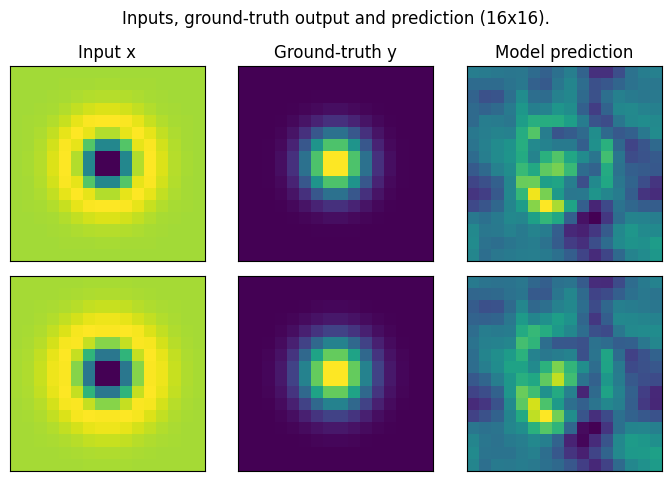

In [1058]:
test_samples = test_loaders[16].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(2):
    data = test_samples[index]
    #data = data_processor.preprocess(data, bat
    # ched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    print(x.unsqueeze(0).shape)
    #out = model(x.unsqueeze(0))

    out = model(x.unsqueeze(0))
    #out = y_normalizer.decode(out)

    #x = x_normalizer.decode(x)

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0].detach().numpy())
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (16x16).', y=0.98)
plt.tight_layout()
fig.show()

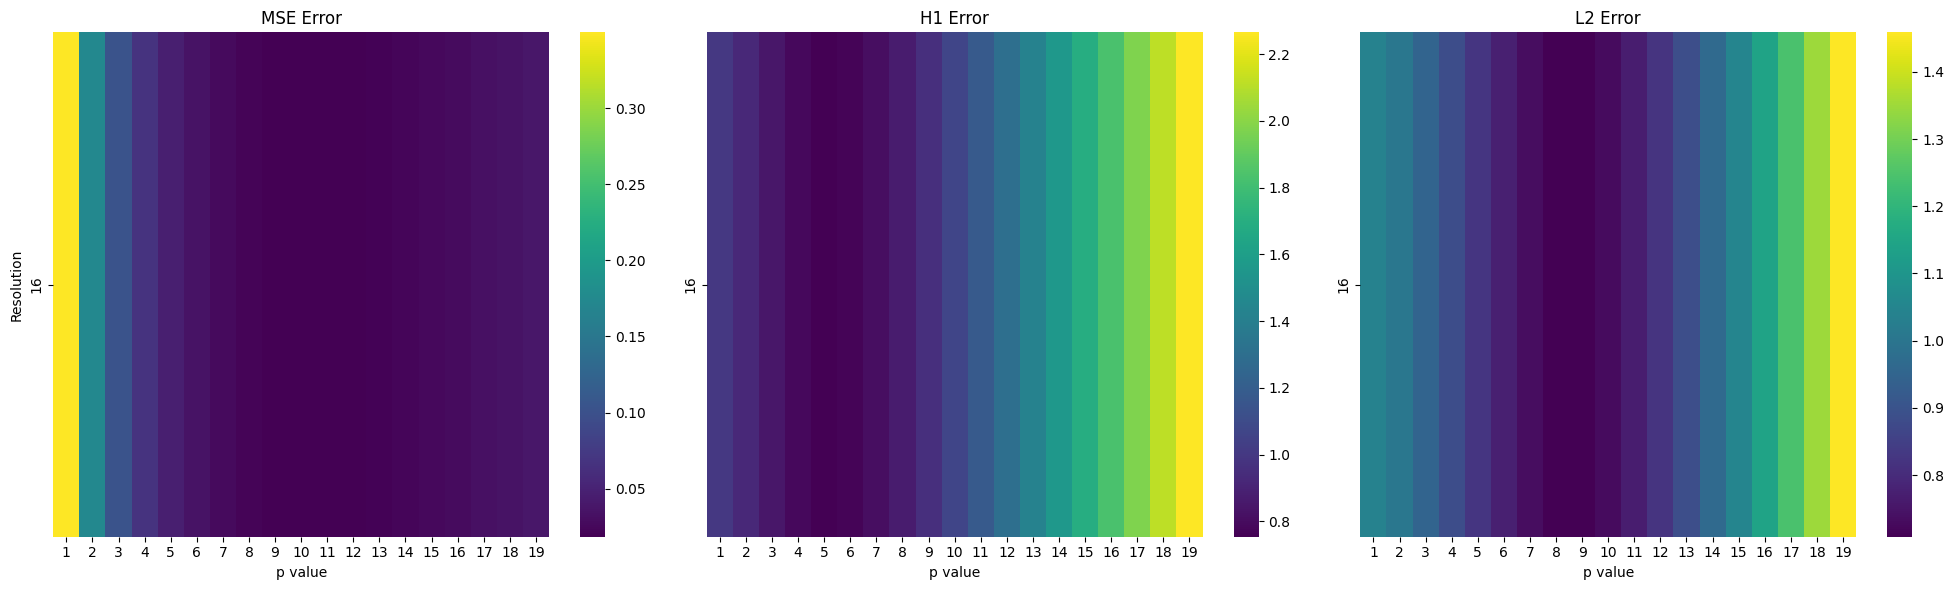

Mean MSE: 0.057957
Mean H1: 1.269120
Mean L2: 0.949637


In [1042]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def test_model_parameters():
    # Test parameters
    resolutions = [16]
    p_values = [i for i in range(1, 20)]
    
    # Initialize error matrices
    mse_errors = np.zeros((len(resolutions), len(p_values)))
    h1_errors = np.zeros((len(resolutions), len(p_values)))
    l2_errors = np.zeros((len(resolutions), len(p_values)))
    
    # Run tests
    for i, res in enumerate(resolutions):
        for j, p in enumerate(p_values):
            # Generate grid
            x = torch.linspace(-1, 1, res, requires_grad=True)
            y = torch.linspace(-1, 1, res, requires_grad=True)
            x, y = torch.meshgrid(x, y)
            
            # Calculate solutions
            u_exact = torch.exp(p*(-x**2 - y**2))
            f = (-4*p + 4*p*p*(x*x + y*y)) * torch.exp(p*(-x*x - y*y))
            u_pred = model(f.reshape(1, 1, res, res))
            
            # Calculate errors
            mse_errors[i,j] = F.mse_loss(u_pred.squeeze(), u_exact).item()
            h1_errors[i,j] = h1loss(u_pred.squeeze(), u_exact).item()
            l2_errors[i,j] = l2loss(u_pred.squeeze(), u_exact).item()
    
    # Plot results
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # MSE errors
    sns.heatmap(mse_errors, ax=ax1, 
                xticklabels=p_values, 
                yticklabels=resolutions,
                cmap='viridis')
    ax1.set_title('MSE Error')
    ax1.set_xlabel('p value')
    ax1.set_ylabel('Resolution')
    
    # H1 errors
    sns.heatmap(h1_errors, ax=ax2,
                xticklabels=p_values,
                yticklabels=resolutions,
                cmap='viridis')
    ax2.set_title('H1 Error')
    ax2.set_xlabel('p value')
    
    # L2 errors
    sns.heatmap(l2_errors, ax=ax3,
                xticklabels=p_values,
                yticklabels=resolutions,
                cmap='viridis')
    ax3.set_title('L2 Error')
    ax3.set_xlabel('p value')
    
    plt.tight_layout()
    plt.show()
    
    return mse_errors, h1_errors, l2_errors

# Run tests
mse_errors, h1_errors, l2_errors = test_model_parameters()

# Print statistics
print(f"Mean MSE: {np.mean(mse_errors):.6f}")
print(f"Mean H1: {np.mean(h1_errors):.6f}")
print(f"Mean L2: {np.mean(l2_errors):.6f}")

tensor(0.0055, grad_fn=<MseLossBackward0>)
tensor(0.5016, grad_fn=<SqueezeBackward0>)
tensor(0.4008, grad_fn=<SqueezeBackward0>)


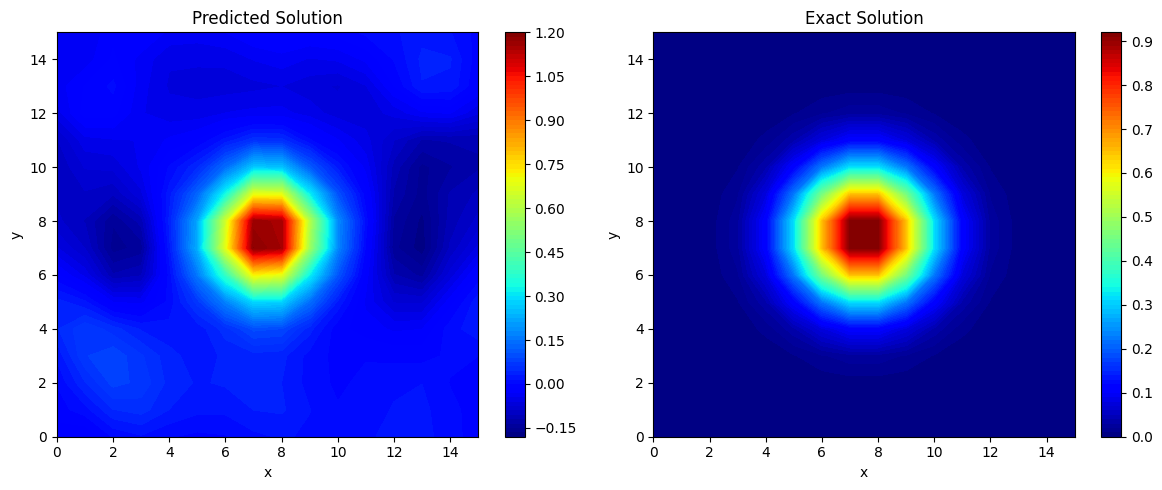

In [1043]:
import torch.nn.functional as F


p = 10
resolution = 16

u_exact = lambda x, y, p: torch.exp(p*(-x**2 - y**2)) 
f_exact = lambda x, y, p: (-4*p + 4*p*p*(x*x + y*y)) * torch.exp(p*(-x*x - y*y)) 


x = torch.linspace(-1 , 1 , resolution , requires_grad = True)
y = torch.linspace(-1,1, resolution ,  requires_grad = True)

x,y = torch.meshgrid(x , y)

u_exact = u_exact((x), (y), p)
f = f_exact((x) , (y) , p)

u_pred = PINO_model(f.reshape(1 ,1 ,resolution , resolution))


print(F.mse_loss(u_pred.squeeze() , u_exact))
print(h1loss(u_pred.squeeze() , u_exact))
print(l2loss(u_pred.squeeze() , u_exact))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Predicted solution
im1 = ax1.contourf(u_pred.squeeze().detach().numpy(), levels=100, cmap='jet')
plt.colorbar(im1, ax=ax1)
ax1.set_title('Predicted Solution')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Exact solution
im2 = ax2.contourf(u_exact.squeeze().detach().numpy(), levels=100, cmap='jet')
plt.colorbar(im2, ax=ax2)
ax2.set_title('Exact Solution')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

plt.tight_layout()
plt.show()


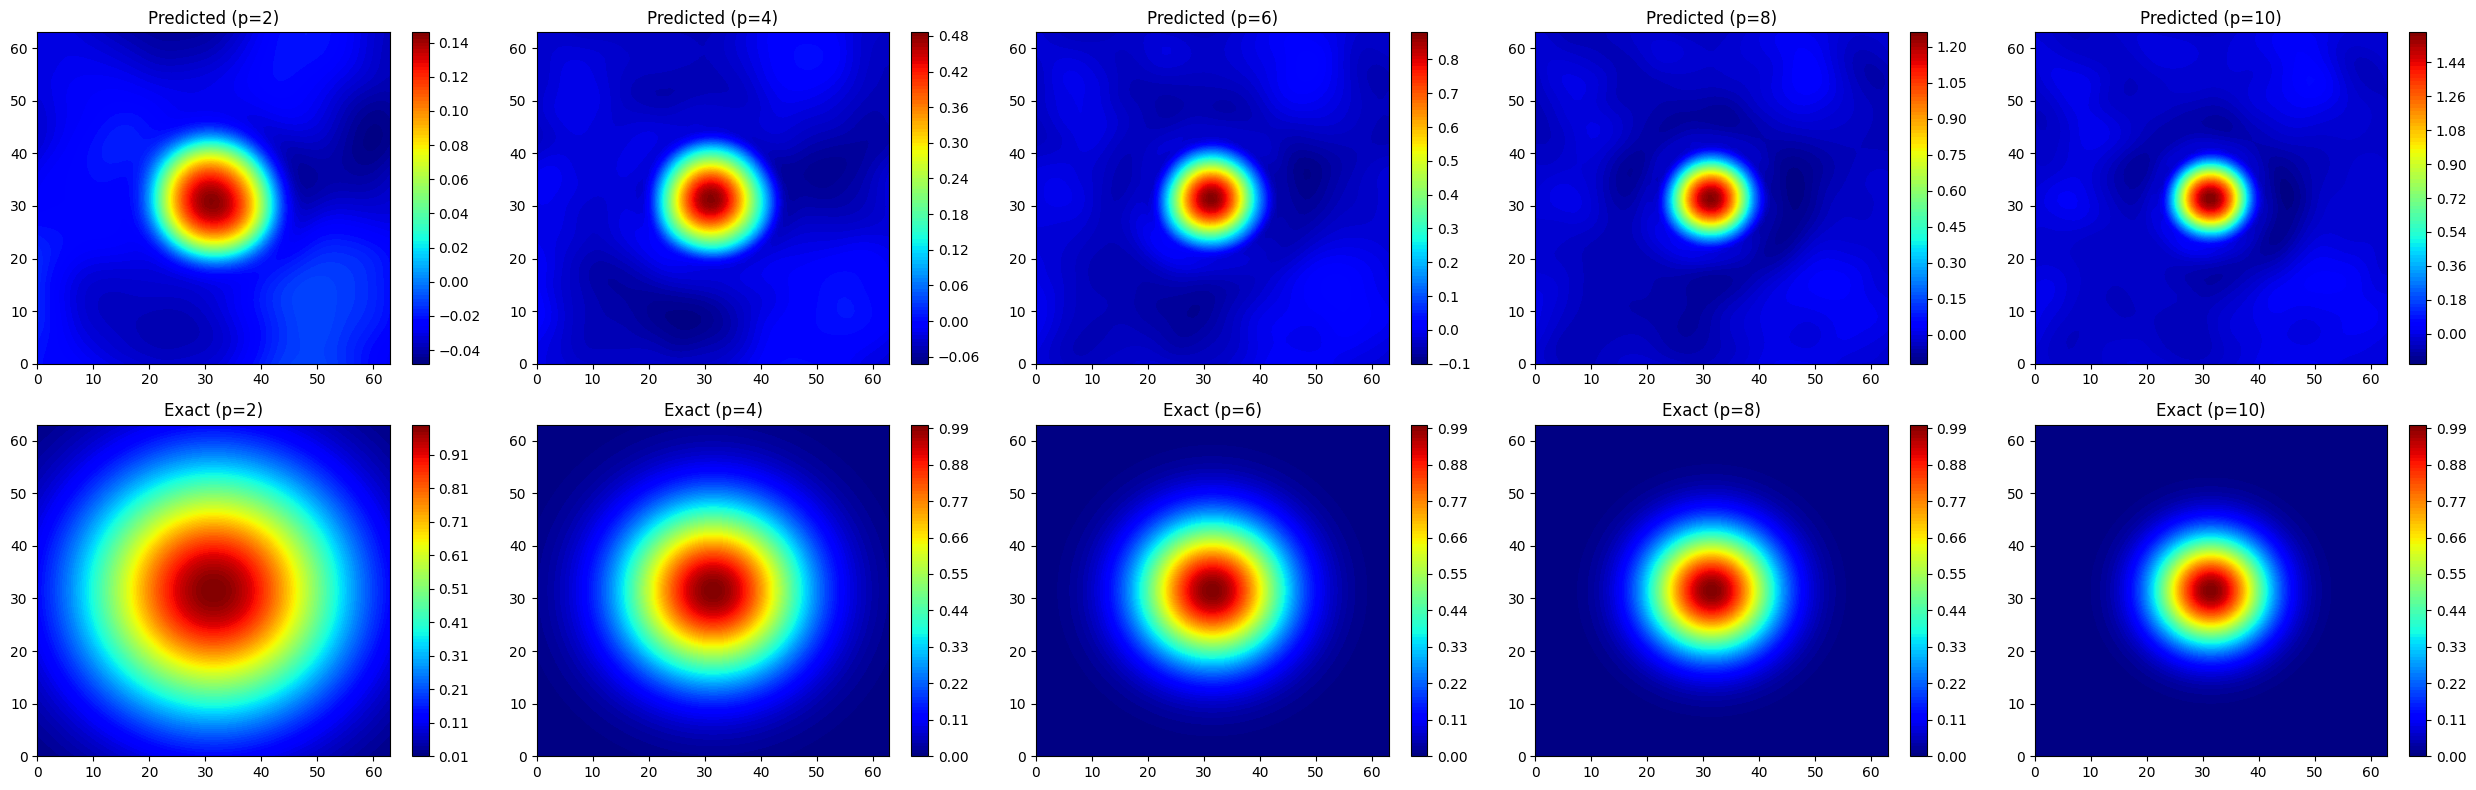

In [1030]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Setup
p_values = [i*2 for i in range(1, 6)]
resolution = 64
x = torch.linspace(-1, 1, resolution, requires_grad=True)
y = torch.linspace(-1, 1, resolution, requires_grad=True)
x, y = torch.meshgrid(x, y)

# Create figure
fig, axes = plt.subplots(2, 5, figsize=(25, 8))

# Generate and plot solutions for each p
for idx, p in enumerate(p_values):
    # Calculate solutions
    u_exact_p = torch.exp(p*(-x**2 - y**2))
    f_p = (-4*p + 4*p*p*(x*x + y*y)) * torch.exp(p*(-x*x - y*y))
    u_pred_p = model(f_p.reshape(1, 1, resolution, resolution))
    
    # Plot predicted solution
    im1 = axes[0, idx].contourf(u_pred_p.squeeze().detach().numpy(), 
                               levels=100, cmap='jet')
    plt.colorbar(im1, ax=axes[0, idx])
    axes[0, idx].set_title(f'Predicted (p={p})')
    
    # Plot exact solution
    im2 = axes[1, idx].contourf(u_exact_p.squeeze().detach().numpy(), 
                               levels=100, cmap='jet')
    plt.colorbar(im2, ax=axes[1, idx])
    axes[1, idx].set_title(f'Exact (p={p})')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Setup
p_values = [1, 5, 10, 12, 15]
x = torch.linspace(-1, 1, 100, requires_grad=True)
y = torch.linspace(-1, 1, 100, requires_grad=True)
x, y = torch.meshgrid(x, y)

# Create figure
fig, axes = plt.subplots(2, 5, figsize=(25, 8))

# Generate and plot solutions for each p
for idx, p in enumerate(p_values):
    # Calculate solutions
    u_exact_p = torch.exp(p*(-x**2 - y**2))
    f_p = (-4*p + 4*p*p*(x*x + y*y)) * torch.exp(p*(-x*x - y*y))
    u_pred_p = model(f_p.reshape(1, 1, 100, 100))
    
    # Plot predicted solution
    im1 = axes[0, idx].contourf(u_pred_p.squeeze().detach().numpy(), 
                               levels=100, cmap='jet')
    plt.colorbar(im1, ax=axes[0, idx])
    axes[0, idx].set_title(f'Predicted (p={p})')
    
    # Plot exact solution
    im2 = axes[1, idx].contourf(u_exact_p.squeeze().detach().numpy(), 
                               levels=100, cmap='jet')
    plt.colorbar(im2, ax=axes[1, idx])
    axes[1, idx].set_title(f'Exact (p={p})')

plt.tight_layout()
plt.show()

In [ ]:
batch_size = 32

for ep in range(100):
    model.train()
    train_mse = 0
    for data in train_loader:
        x, y = data['x'] , data['y']
        #print(x.shape)

        optimizer.zero_grad()
        # loss = F.mse_loss(model(x).view(-1), y.view(-1), reduction='mean')
        out = model(x.reshape(x.shape[0] , 1 , 32 , 32 ))
        out = y_normalizer.decode(out)
        #print(f"befor {out.shape}")
        #Laplacien = torch.cat([derivation(out[i],X,order = 2) + derivation(out[i],Y,order = 2) for i in range(x.shape[0]) ] , dim = -1).reshape(x.shape[0] , 1 , 32 , 32 )
        #print(train_loss(x.view(batch_size,-1), Laplacien.view(batch_size,-1)))
        y = y_normalizer.decode(y)
        loss = train_loss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward(retain_graph = True)


        optimizer.step()
    scheduler.step()

    if ep % 10 == 0 :
        print(f'loss id {loss}')



In [ ]:
import torch.nn.functional as F

p = 1

u_exact = lambda x, y, p: torch.exp(p*(-x**2 - y**2))
f_exact = lambda x, y, p: (-4*p + 4*p*p*(x*x + y*y)) * torch.exp(p*(-x*x - y*y))

x = torch.linspace(-1 , 1 , 32 , requires_grad = True)
y = torch.linspace(-1,1, 32 ,  requires_grad = True)

x,y = torch.meshgrid(x , y)

u_exact = u_exact((x), (y), p)
f = f_exact((x) , (y) , p)

u_pred = model(f.reshape(1 ,1 ,32 , 32))
u_pred = y_normalizer.decode(u_pred)


print(F.mse_loss(u_pred.squeeze() , u_exact))

plt.figure(figsize=(6,5))
plt.contourf(u_pred.squeeze().detach().numpy(), levels=100, cmap='jet')
plt.colorbar()
plt.title('Predicted solution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure(figsize=(6,5))
plt.contourf(u_exact.squeeze().detach().numpy(), levels=100, cmap='jet')
plt.colorbar()
plt.title('Exact Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
